# Analysis and Visualization Tutorial for ST and SM data

This tutorial provides a step-by-step guide for analyzing spatial transcriptomics (ST) and spatial metabolomics (SM) data using spatialMETA. The tutorial covers the following analysis steps:

1. Marker Feature Analysis: Identifying marker genes and metabolites that are differentially expressed in different cell types or regions of interest.
2. Metabolite Annotation and Enrichment: Annotating and enriching metabolites using the HMDB database and hypergeometric distribution test methods.
3. Correlation Analysis: Exploring the correlation between genes and metabolites in specific clusters or all clusters.
4. Spatial TOI (Trajectory of Interest) Analysis: Analyzing gene expression and metabolite intensity gradients along a user-defined trajectory of interest.
5. Spatial ROI (Region of Interest) Analysis: Analyzing gene expression and metabolite intensity within user-defined regions of interest.
6. Spatial Network Analysis: Analyzing the spatial network of gene expression and metabolite intensity.

Please refer to the code cells in the notebook for detailed implementation and visualization of each analysis step.

In [2]:
import spatialmeta as smt
from spatialmeta.model import AlignmentVAE
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Marker Feature Analysis

This step involves identifying marker genes and metabolites that are differentially expressed in different clusters or regions of interest. To perform marker feature analysis, we can use the `rank_gene_and_metabolite_groups()` function from the `spatialmeta` package. After obtaining the results, we can visualize them using the `plot_marker_gene_metabolite()` function, which generates scatter plots.

In [3]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_final.h5ad")

In [4]:
smt.pp.rank_gene_and_metabolite_groups(
    joint_adata,
    groupby_ST = "celltype_ST_SM",
    groupby_SM = "celltype_ST_SM",
)

In [5]:
gene_df = pd.DataFrame(joint_adata.uns['rank_genes_groups']['names']).head(3)
ST_marker_feature_list = [gene_df[col].tolist() for col in gene_df.columns]

In [6]:
metabolite_df = pd.DataFrame(joint_adata.uns['rank_metabolites_groups']['names']).head(2)
SM_marker_feature_list = [metabolite_df[col].tolist() for col in metabolite_df.columns]

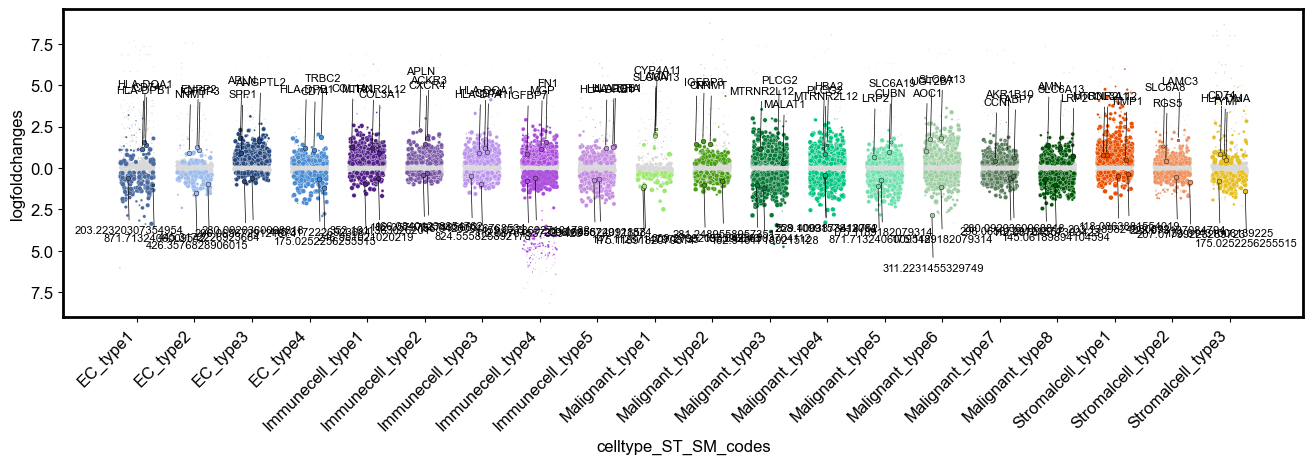

In [9]:
smt.pl.plot_marker_gene_metabolite(
    joint_adata,
    groupby="celltype_ST_SM",
    ST_marker_feature_list = ST_marker_feature_list,
    SM_marker_feature_list = SM_marker_feature_list,
     figsize=(16, 4),
        palette={
            'EC_type1': "#4A6BA0",
            'EC_type2': "#9DBCED",
            'EC_type3': "#28497F",
            'EC_type4': "#4A8BD1",
            'Immunecell_type1': "#522188",
            'Immunecell_type2': "#7A58A5",
            'Immunecell_type3': "#BB94ED",
            'Immunecell_type4': "#AC4EDD",
            'Immunecell_type5': "#C58DE2",
            'Malignant_type1': "#9DE86D",
            'Malignant_type2': "#499E12",
            'Malignant_type3': "#097A39",
            'Malignant_type4': "#00C67F",
            'Malignant_type5': "#6CE0AB",
            'Malignant_type6': "#9DCEA2",
            'Malignant_type7': "#597C5C",
            'Malignant_type8': "#005908",
            'Stromalcell_type1': "#EA4E00",
            'Stromalcell_type2': "#EF915E",
            'Stromalcell_type3': "#E5BE1C",
              }
)

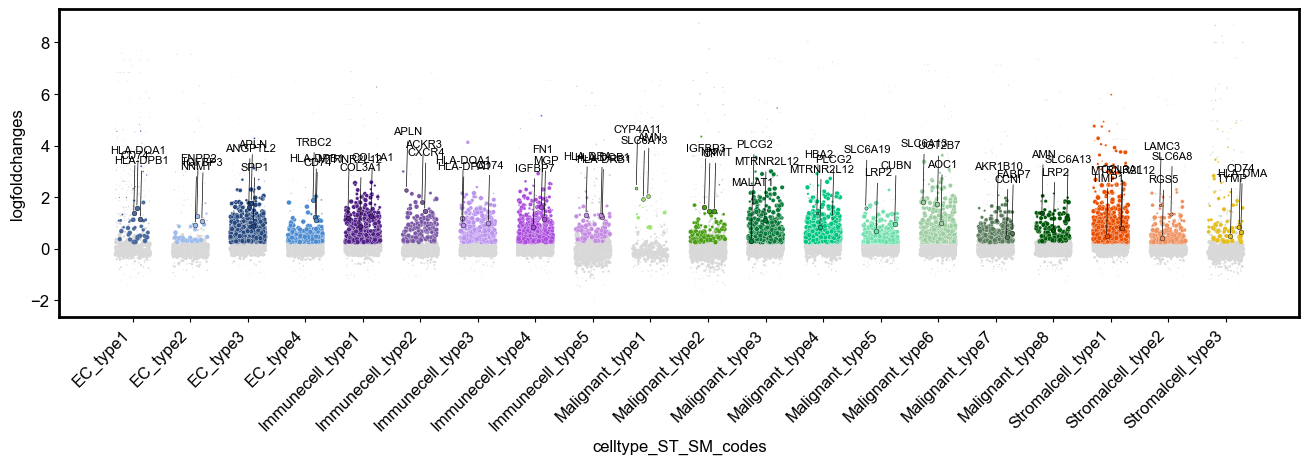

In [10]:
smt.pl.plot_markerfeature(
    joint_adata,
    groupby="celltype_ST_SM",
    palette={
            'EC_type1': "#4A6BA0",
            'EC_type2': "#9DBCED",
            'EC_type3': "#28497F",
            'EC_type4': "#4A8BD1",
            'Immunecell_type1': "#522188",
            'Immunecell_type2': "#7A58A5",
            'Immunecell_type3': "#BB94ED",
            'Immunecell_type4': "#AC4EDD",
            'Immunecell_type5': "#C58DE2",
            'Malignant_type1': "#9DE86D",
            'Malignant_type2': "#499E12",
            'Malignant_type3': "#097A39",
            'Malignant_type4': "#00C67F",
            'Malignant_type5': "#6CE0AB",
            'Malignant_type6': "#9DCEA2",
            'Malignant_type7': "#597C5C",
            'Malignant_type8': "#005908",
            'Stromalcell_type1': "#EA4E00",
            'Stromalcell_type2': "#EF915E",
            'Stromalcell_type3': "#E5BE1C",
              },
    marker_feature_list = ST_marker_feature_list,
     figsize=(16, 4)
)

## Metabolite Annotation and Enrichment

In this step, metabolites are annotated and enriched using the HMDB database and hypergeometric distribution test methods. To annotate the metabolites, you can use the `smt.pp.metabolite_annotation()` function. After obtaining the annotation results, you can add them to the `joint_adata.var` using the `merge_and_assign_var_data()` function. To calculate metabolite enrichment, you can use the `calculate_metabolite_enrichment()` function.

### Read data

In [3]:
adata_SM = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_SM_raw.h5ad")

In [4]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800_afterVAE.h5ad")

### Metabolites annotation

In [5]:
adata_SM_neg = adata_SM[:,adata_SM.var['type']=="SM_neg"]

In [6]:
adata_SM_pos = adata_SM[:,adata_SM.var['type']=="SM_pos"]

In [7]:
var_pos_1 = smt.pp.metabolite_annotation(adata_SM_pos,
                      adduct_method='add',
                      adduct_type='H',
                      tolerance_ppm = 5)
var_pos_2 = smt.pp.metabolite_annotation(adata_SM_pos,
                      adduct_method='add',
                      adduct_type='Na',
                      tolerance_ppm = 5)
var_pos_3 = smt.pp.metabolite_annotation(adata_SM_pos,
                      adduct_method='add',
                      adduct_type='K',
                      tolerance_ppm = 5)
filtered_var_pos_1 = var_pos_1[var_pos_1['accession'].notnull()]
filtered_var_pos_2 = var_pos_2[var_pos_2['accession'].notnull()]
filtered_var_pos_3 = var_pos_3[var_pos_3['accession'].notnull()]
var_pos_df = pd.concat([filtered_var_pos_1, filtered_var_pos_2, filtered_var_pos_3], ignore_index=True)

/home/rolan/Documents/spatialMETA/spatialmeta/preprocess/_metabolite_annotation.py:101: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_SM.var['accession'] = var_df['accession'].values


In [8]:
var_neg_1 = smt.pp.metabolite_annotation(adata_SM_neg,
                      adduct_method='sub',
                      adduct_type='H',
                      tolerance_ppm = 5)
var_neg_2 = smt.pp.metabolite_annotation(adata_SM_neg,
                      adduct_method='sub',
                      adduct_type='Cl',
                      tolerance_ppm = 5)
filtered_var_neg_1 = var_neg_1[var_neg_1['accession'].notnull()]
filtered_var_neg_2 = var_neg_2[var_neg_2['accession'].notnull()]
var_neg_df = pd.concat([filtered_var_neg_1, 
                        filtered_var_neg_2], ignore_index=True)

/home/rolan/Documents/spatialMETA/spatialmeta/preprocess/_metabolite_annotation.py:101: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_SM.var['accession'] = var_df['accession'].values


In [9]:
var_anno_df = pd.concat([var_pos_df,var_neg_df])

In [11]:
columns_to_assign = ['accession', 'metabolite_name', 'iupac_name', 'chemical_formula', 
                     'kegg', 'direct_parent', 'class', 'sub_class']
smt.pp.merge_and_assign_var_data(joint_adata, var_anno_df, columns_to_assign)

In [12]:
joint_adata

AnnData object with n_obs × n_vars = 2921 × 2800
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'joint_clusters', 'SM_clusters', 'ST_clusters', 'VAE_clusters_latent10'
    var: 'name', 'type', 'highly_variable_moranI', 'accession', 'metabolite_name', 'iupac_name', 'chemical_formula', 'kegg', 'direct_parent', 'class', 'sub_class'
    uns: 'SM_clusters_colors', 'ST_clusters_colors', 'VAE_clusters_latent10', 'VAE_clusters_latent10_colors', 'joint_clusters', 'joint_clusters_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_emb', 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'normalized', 'reconstruction'
    obsp: 'connectivities', 'dista

In [13]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800_afterVAE_annoSM.h5ad")

### metabolites enrichment

In [4]:
metabolite_df = pd.read_csv("./spatialmeta_tutorial/data/metabolite_for_imm_clusters_withanno.csv",index_col=0)

In [5]:
type = "Immunecell_type3"
metabolite_type_list = list(set(metabolite_df[metabolite_df['Type']=="Immunecell_type3"]['accession'].dropna()))

In [6]:
class_df = smt.pp.calculate_metabolite_enrichment(metabolite_type_list,
                                                  type = "sub_class")

Text(0, 0.5, 'class')

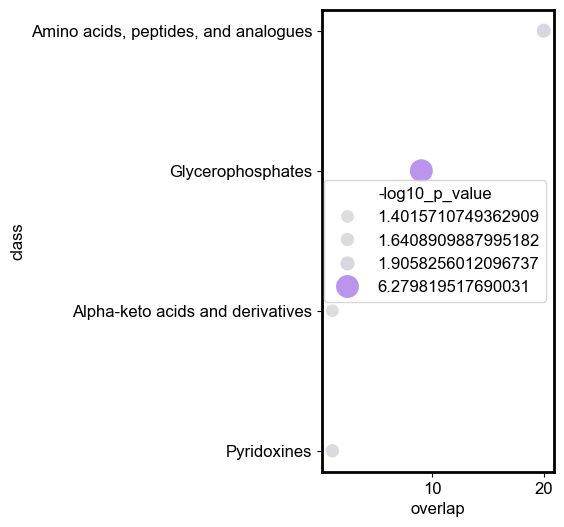

In [7]:
class_df['-log10_p_value'] = -class_df['p_value'].apply(lambda x: np.log10(x))
# Create a dot plot using Seaborn
plt.figure(figsize=(3, 6))
sns.scatterplot(data=class_df.head(4), 
                y='class', 
                size='-log10_p_value', x='overlap', 
                hue='-log10_p_value',
                sizes=(100, 300),
                palette = smt.pl.make_colormap(['#DDDDDD', '#BB94ED']))
# Customize the plot
plt.xlabel('overlap')
plt.ylabel('class')

## Correlation Analysis

This step focuses on exploring the correlation between genes and metabolites in specific clusters or all clusters. 

To calculate the correlation coefficients between genes and metabolites within specific clusters, you can use the `smt.pp.corrcoef_stsm_ingroup()` function. This function takes in the joint annotated AnnData object, a list of genes or metabolites, the type of list (gene or metabolite), and the grouping variable (e.g., cell type or cluster). It returns a correlation matrix.

To visualize the correlation matrix as a heatmap, you can use the `smt.pl.plot_corrcoef_stsm_ingroup()` function. 

In [11]:
gene_list = ["AMN","CYP2J2","ACADL","CYP4V2","CYP4A11","ACSM2A","ACAD11"]

In [12]:
smt.pp.corrcoef_stsm_ingroup(
    joint_adata,
    inputlist=gene_list,
    list_type="gene",
    groupby="celltype_ST_SM",
    ntop=5
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 39992.39it/s]


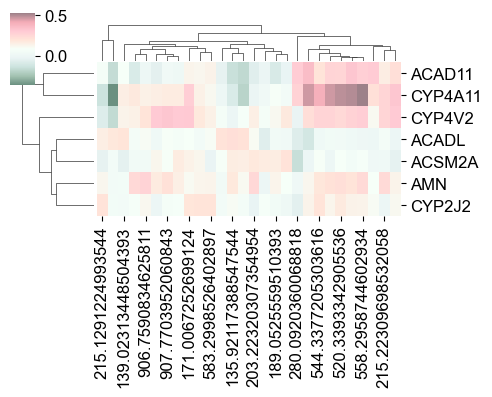

In [13]:
smt.pl.plot_corrcoef_stsm_ingroup(
    joint_adata,
    row_cluster=True,
    cluster='Immunecell_type3',
    col_cluster=True, 
    figsize=(5, 4)
)

In [14]:
joint_adata_Immune = joint_adata[joint_adata.obs['celltype_ST']=="Immune cell"]

To plot a volcano plot for gene correlation coefficients, you can use the `plot_volcano_corrcoef_gene()` function from the `smt.pl` module. Here's an example:

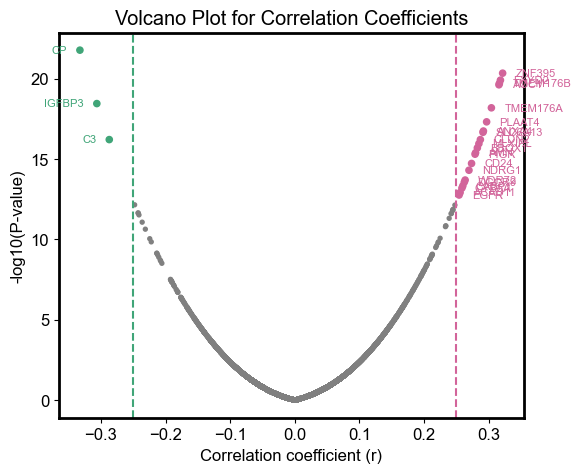

In [18]:
smt.pl.plot_volcano_corrcoef_gene(
    joint_adata_Immune,
    metabolite = '267.1355665990693',
    show=False
)

To plot a volcano plot for metabolite correlation coefficients, you can use the `plot_volcano_corrcoef_metabolite()` function from the `smt.pl` module. Here's an example:

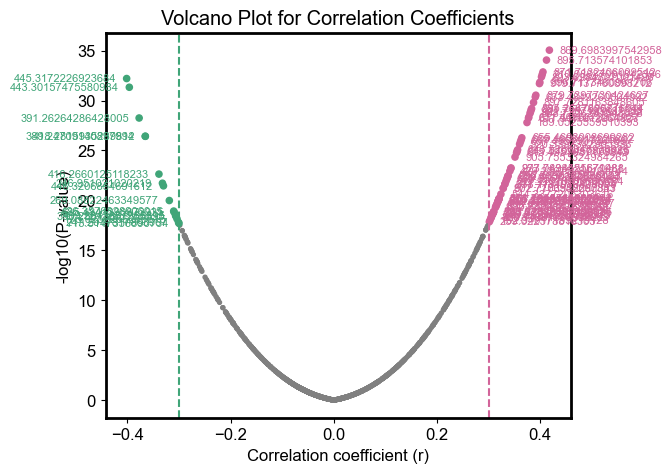

In [20]:
smt.pl.plot_volcano_corrcoef_metabolite(
    joint_adata_Immune,
    gene = 'CYP2J2',
    threshold=0.3,
    color_threshold=0.3,
    show=False
)

## Spatial TOI

We provide an interactive analysis of gene expression and metabolite intensity gradients along a trajectory of interest (TOI). The TOI can be drawn by the user, enabling the calculation and visualization of these gradients.

In [21]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_final.h5ad")

In [22]:
wrapper = smt.pl.Wrapper(joint_adata)

To initialize the interactive plotly app using the `smt.pl.Wrapper()` function, you need to define and add a port number. The port number is a unique identifier that allows the app to run on a specific network port. Here's an example of how to use the `smt.pl.Wrapper()` function with a port number:

In [24]:
app = wrapper.to_plotly(init_feature='CD8A')
app.run(debug=False,port=5050) 

[2024-06-24 20:40:18,875] ERROR in app: Exception on /_alive_00442991-2a13-4746-b597-abc92ec90e24 [GET]
Traceback (most recent call last):
  File "/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/flask/app.py", line 1463, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/flask/app.py", line 872, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/flask/app.py", line 868, in full_dispatch_request
    rv = self.preprocess_request()
  File "/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/flask/app.py", line 1243, in preprocess_request
    rv = self.ensure_sync(before_func)()
  File "/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/dash/dash.py", line 1391, in _setup_server
    _validate.validate_layout(self.layout, self._layout_value())
  File "/home/rolan/miniconda3/envs/sp

In [40]:
joint_adata_TOI.obs['trajectory_1'] = -1
joint_adata_TOI.obs.iloc[joint_adata_TOI.uns['trajectory']['trajectory_1']['indices'], -1] = joint_adata_TOI.uns['trajectory']['trajectory_1']['locations']

To visualize the trajectory, we can use the `plot_trajectory_with_arrows()` function. This function creates a plot showing the trajectory of cells along with arrows indicating the direction of the trajectory.

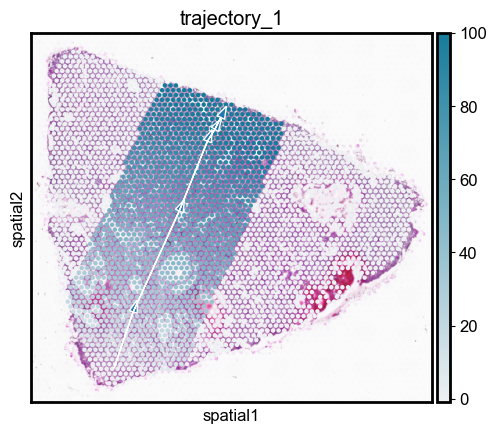

In [41]:
smt.pl.plot_trajectory_with_arrows(
    joint_adata_TOI,
    color_map = sns.light_palette("#157B9B",as_cmap=True)
)

To visualize the data and return the results, we can use the `plot_clustermap_with_smoothing()` function. This function creates a clustermap with smoothing, allowing us to visualize the spatial distribution of features in our data.

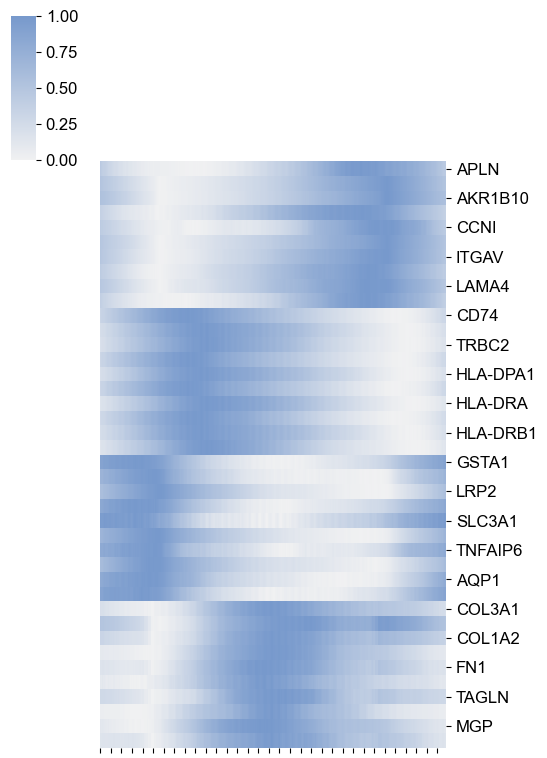

In [43]:
data_dict = smt.pl.plot_clustermap_with_smoothing(
    joint_adata_TOI,
    window_size=1000,
    cmap=sns.light_palette("#79C",as_cmap=True),
    figsize=(5,8),
    return_data=True
)

In [44]:
data_dict

{'X': array([[ 2.88149357,  2.87793032,  2.86860513, ...,  2.88494798,
          2.88571348,  2.88504242],
        [46.65458736, 46.62740841, 46.60091998, ..., 46.76389561,
         46.72275973, 46.68587772],
        [ 1.49135783,  1.48822237,  1.48652688, ...,  1.50017989,
          1.49699788,  1.49449099],
        ...,
        [ 0.09555691,  0.09555691,  0.09555691, ...,  0.09555691,
          0.09555691,  0.09555691],
        [ 7.45499336,  7.45161969,  7.4474938 , ...,  7.45708365,
          7.45938014,  7.45832921],
        [ 0.26259896,  0.26259896,  0.26259896, ...,  0.26259896,
          0.26259896,  0.26259896]]),
 'varnames': array(['APLN', 'SPP1', 'AKR1B10', 'FABP7', 'CCNI', 'CP', 'ITGAV', 'CXCR4',
        'LAMA4', 'ANGPTL2', 'CD74', 'HLA-DPB1', 'TRBC2', 'HLA-DQA1',
        'HLA-DPA1', 'GBP4', 'HLA-DRA', 'HLA-DQB1', 'HLA-DRB1', 'C1QA',
        'GSTA1', 'UGT2B7', 'LRP2', 'PDZK1IP1', 'SLC3A1', 'CUBN', 'TNFAIP6',
        'NAT8', 'AQP1', 'GSTA2', 'COL3A1', 'COL1A1', 'COL1A2', '

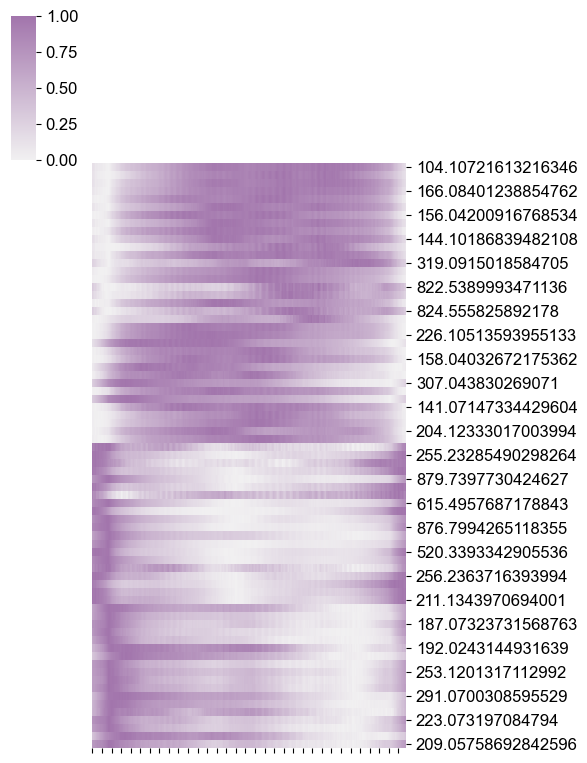

In [45]:
smt.pl.plot_clustermap_with_smoothing(
    joint_adata_TOI,
    window_size=300, 
    cmap = sns.light_palette("#a275ac",as_cmap=True),
    figsize=(5,8),
    key = 'rank_metabolites_groups',
    feature_top=20,
    return_data = False
)

To plot the features trajectory, you can use the `plot_features_trajectory()` function. This function allows you to visualize the trajectory of features in your data. Here's an example:

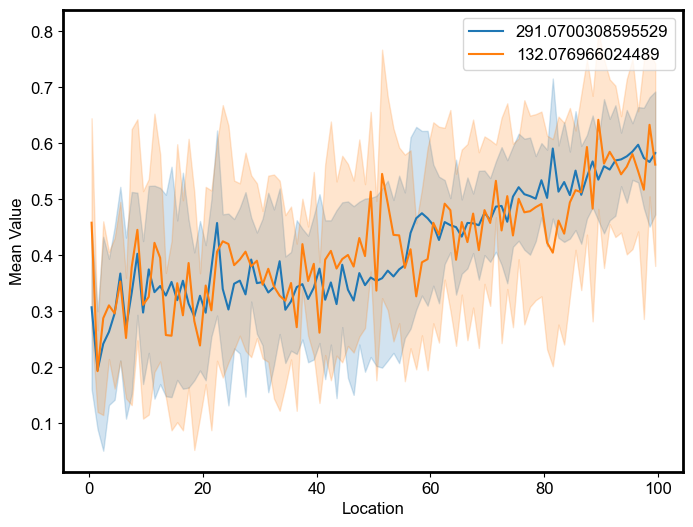

In [46]:
smt.pl.plot_features_trajectory(
    joint_adata_TOI,
    features = ['291.0700308595529','132.076966024489'],
    bins=100,
    scale=True,
    figsize=(8,6)
)

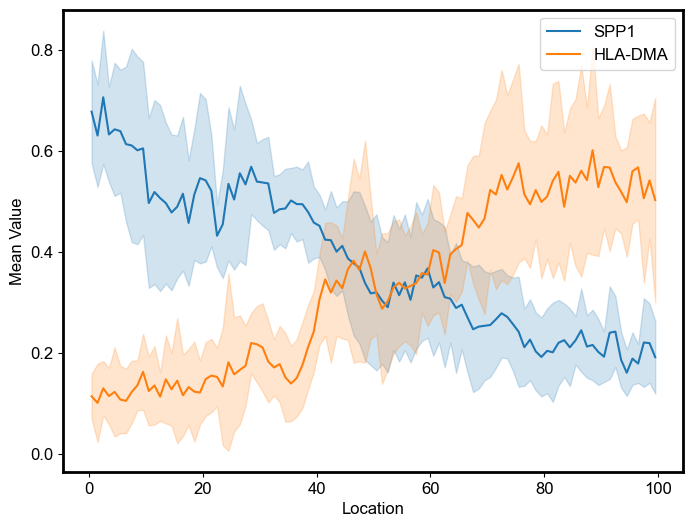

In [47]:
smt.pl.plot_features_trajectory(
    joint_adata_TOI, 
    features = ['SPP1','HLA-DMA'], 
    bins=100,
    scale=True,
    figsize=(8,6)
)

In [ ]:
joint_adata_TOI.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_TOI.h5ad")

## Spatial ROI

This analysis step involves analyzing specific regions of interest and identifying marker genes and metabolites associated with these regions.

In [49]:
joint_adata_ROI.obs['ROI_type1'].value_counts()

ROI_type1
undefined    2024
Immune        558
Malignant     339
Name: count, dtype: int64

[<Axes: title={'center': 'ROI_type1'}, xlabel='spatial1', ylabel='spatial2'>]

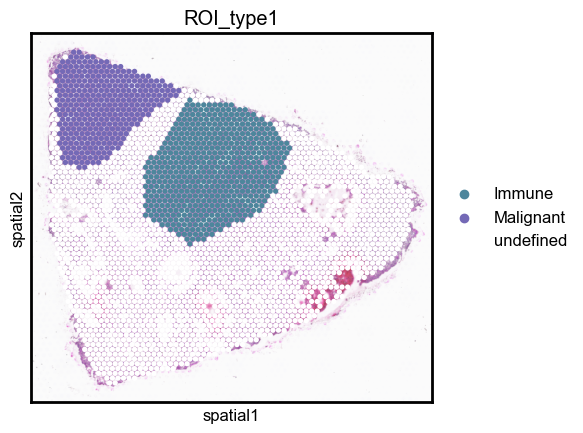

In [51]:
sc.pl.spatial(
    joint_adata_ROI,
    img_key="hires",
    color=["ROI_type1"],
    show=False,
    alpha_img=0.8,
    size=1.2,
    palette = {
        "Immune":"#4D869C",
        "Malignant": "#7469B6",
        "undefined": "#FFFFFF",
    }
)

In [54]:
joint_adata_ROI_filter = joint_adata_ROI[joint_adata_ROI.obs['ROI_type1']!="undefined"]
smt.pp.rank_gene_and_metabolite_groups(
    joint_adata_ROI_filter,
    groupby_ST = "ROI_type1",
    groupby_SM = "ROI_type1",
    key_added_ST= "rank_genes_groups_byROI_type1",
    key_added_SM = "rank_metabolites_groups_byROI_type1",    
)

In [55]:
gene_df = pd.DataFrame(joint_adata_ROI_filter.uns['rank_genes_groups_byROI_type1']['names']).head(5)
ST_marker_feature_list = [gene_df[col].tolist() for col in gene_df.columns]
metabolite_df = pd.DataFrame(joint_adata_ROI_filter.uns['rank_metabolites_groups_byROI_type1']['names']).head(3)
SM_marker_feature_list = [metabolite_df[col].tolist() for col in metabolite_df.columns]

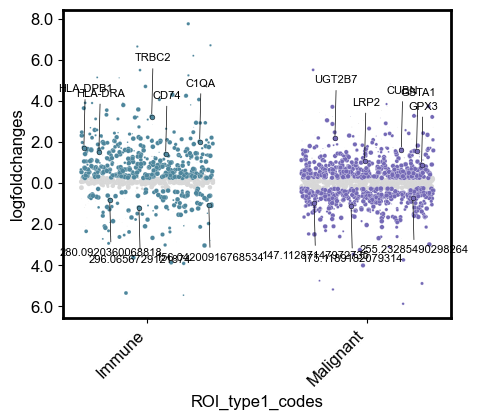

In [57]:
smt.pl.plot_marker_gene_metabolite(
    joint_adata_ROI_filter,
    groupby="ROI_type1",
    palette = {
        "Immune":"#4D869C",
        "Malignant": "#7469B6",
    },
    ST_marker_feature_list = ST_marker_feature_list,
    SM_marker_feature_list = SM_marker_feature_list,
     figsize=(5, 4),
    key_ST= "rank_genes_groups_byROI_type1",
    key_SM = "rank_metabolites_groups_byROI_type1",    
)

In [ ]:
joint_adata_ROI.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_ROI.h5ad")

## Spatial Network

To perform spatial network analysis, we can use the `plot_network()` function from the SpatialToolkit library. This function allows us to visualize and analyze the interactions between genes and metabolites in a spatial context.

Here's an example of how to use the `plot_network()` function:

In [58]:
merge_adata = sc.read_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_final.h5ad")

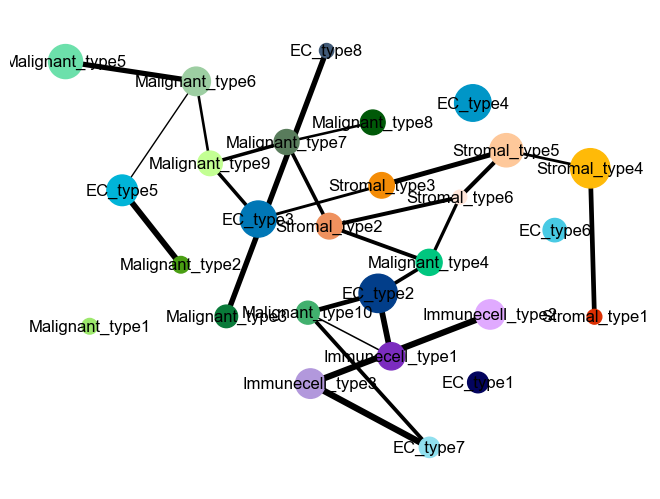

In [60]:
seed = 2
smt.pl.plot_network(
    merge_adata,
     groupby = 'subcelltype',
     seed = 2,
     top_n_neighbors = 3,
     node_scale_factor = 800,
     edge_weight_threshold = 0.1,
     edge_scale_factor = 10,
     node_min_size = 100,
     split_by= 'sample',
     palette= {
        'EC_type1': "#03045e",
        'EC_type2': "#023e8a",
        'EC_type3': "#0077b6",
        'EC_type4': "#0096c7",
        'EC_type5': "#00b4d8",
        'EC_type6': "#48cae4",
        'EC_type7': "#90e0ef",
        'EC_type8': "#415a77",
        'Immunecell_type1': "#7b2cbf",
        'Immunecell_type2': "#e0aaff",
        'Immunecell_type3': "#b298dc",
        'Malignant_type1': "#9DE86D",
        'Malignant_type2': "#499E12",
        'Malignant_type3': "#097A39",
        'Malignant_type4': "#00C67F",
        'Malignant_type5': "#6CE0AB",
        'Malignant_type6': "#9DCEA2",
        'Malignant_type7': "#597C5C",
        'Malignant_type8': "#005908",
        'Malignant_type9': "#C3FF93",
        'Malignant_type10': "#41B06E",
        'Stromal_type1': "#dc2f02",
        'Stromal_type2': "#EF915E",
        'Stromal_type3': "#f48c06",
        'Stromal_type4': "#ffba08",
        'Stromal_type5': "#fec89a",
        'Stromal_type6': "#ffe5d9",
     }
    show = True
)